# 因子回测

## 导入模块

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy import stats
import feather
import os
import statsmodels.api as sm
import sunlandsdatasdk as sd

## 定义回测区间

In [2]:
start_date = '2019-01-01'
end_date = '2025-01-01'

## 读入和处理数据

### 读入 ST 股票

读入全公司列表

In [3]:
issues = feather.read_dataframe('../data/issues.feather')
issues_tot = issues['issue'].sort_values().unique()

读入 ST 股票

In [4]:
# sd.auth('*', '*')
# st = sd.get_st_issue(issues=list(issues_tot), start_date=start_date, end_date=end_date)
# st = st.set_index('date').stack().reset_index().rename(columns={'level_1': 'issue', 0: 'st'})
# feather.write_dataframe(st, '../data/st.feather')
st = feather.read_dataframe('../data/st.feather')

### 读入日线数据

读入日线数据

In [5]:
price_1d = feather.read_dataframe('../data/StockPriceK1d_20241231.feather')

计算调仓日

In [6]:
trade_date = price_1d['date'].sort_values().unique()
mes = pd.date_range(start=start_date, end=end_date, freq='1ME')
adj_date = np.array([], dtype=np.datetime64)
for me in mes:
    trade_date_before = trade_date[trade_date <= me]
    ad = trade_date_before[-1]
    adj_date = np.append(adj_date, ad)
map_mon_adj = {ad.year * 100 + ad.month: ad for ad in adj_date}

计算每两个调仓日之间的收益

In [7]:
price_1d['year_mon'] = price_1d['date'].dt.year * 100 + price_1d['date'].dt.month

def ret_acc_prod(price_1d):
    ret = price_1d['ret']
    return (1 + ret).prod() - 1

def ret_acc(price_1d):
    preclose = price_1d.iloc[0]['preclose']
    close = price_1d.iloc[-1]['close']
    return (close - preclose) / preclose

def ret_acc_adj(price_1d):
    hfq = price_1d['close'] * price_1d['adj']
    return hfq / hfq.shift(1) - 1

def ret_acc_adj_2(price_1d):
    open_hfq = price_1d.iloc[0]['open'] * price_1d.iloc[0]['adj']
    close_hfq = price_1d.iloc[-1]['close'] * price_1d.iloc[-1]['adj']
    return close_hfq / open_hfq - 1

# price_prod = (
#     price_1d[(price_1d['date'] >= start_date) & (price_1d['date'] <= end_date)]
#         .groupby(['issue', 'year_mon'])[['preclose', 'close', 'adj', 'ret']]
#         .apply(ret_acc_prod)
#         .reset_index()
# )

mon_last = (
    price_1d[(price_1d['date'] >= '2018-12-01') & (price_1d['date'] <= end_date)]
        .groupby(['issue', 'year_mon'])
        .last()
)
price_adj = (
    mon_last
        .groupby('issue', group_keys=False)
        .apply(ret_acc_adj)
        .reset_index()
        .dropna()
)

price_adj = price_adj.rename(columns={0: 'ret'})
price_adj['date'] = price_adj['year_mon'].apply(map_mon_adj.get)
price_adj['ret_next'] = price_adj.groupby('issue')['ret'].shift(-1)
price_adj = price_adj[['issue', 'date', 'ret', 'ret_next']]
price_adj = price_adj.dropna(subset='ret_next')

剔除股票

In [8]:
def newly_listed(date, timedelta='180D'):
    start_date = date.min()
    newly = (date <= start_date + pd.Timedelta(timedelta))
    return newly

price_1d['newly_listed'] = (
    price_1d
        .groupby('issue')['date']
        .transform(newly_listed)
)

price_adj = pd.merge(
    price_adj,
    price_1d[['issue', 'date', 'newly_listed', 'is_limit_sell', 'is_limit_buy']],
    on=['issue', 'date'],
    how='left'
)
price_adj = pd.merge(
    price_adj,
    st,
    on=['issue', 'date'],
    how='left'
)
price_adj['st'] = price_adj['st'].ffill()

price_adj = price_adj[
    (~price_adj['newly_listed']) &
    (~price_adj['is_limit_buy'].astype(bool)) &
    (~price_adj['is_limit_sell'].astype(bool))
]
price_adj = price_adj[~price_adj['st']]
price_adj = price_adj[['issue', 'date', 'ret', 'ret_next']]

C:\Users\admin\AppData\Local\Temp\ipykernel_54392\4021416782.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_adj['st'] = price_adj['st'].ffill()


### 计算基准

中证 500

In [9]:
# sd.auth('*', '*')
# index_bar = sd.get_index_bar('000906', start_date='2018-12-01', end_date=end_date)
# index_bar['date'] = pd.to_datetime(index_bar['date'])
# index_bar = index_bar.drop(columns='_id')

# index_bar['year_mon'] = index_bar['date'].dt.year * 100 + index_bar['date'].dt.month
# index_bar = index_bar.groupby('year_mon').last()
# ret_index = index_bar['close'] / index_bar['close'].shift(1) - 1
# ret_index = ret_index.reset_index().dropna().rename(columns={'close': 'ret'})
# ret_index['date'] = ret_index['year_mon'].apply(map_mon_adj.get)
# ret_index['ret_next'] = ret_index['ret'].shift(-1)
# ret_index = ret_index.dropna()
# ret_index = ret_index.set_index('date')

# os.makedirs('../data/benchmark/', exist_ok=True)
# feather.write_dataframe(ret_index, '../data/benchmark/benchmark_000906.feather')
# ret_index

全样本等权

In [10]:
# ret_sample = (
#     price_adj
#         .groupby('date')[['ret', 'ret_next']].mean()
# )
# os.makedirs('../data/benchmark/', exist_ok=True)
# feather.write_dataframe(ret_sample, '../data/benchmark/benchmark_sample.feather')
# ret_sample

## IC 测试

In [11]:
def IC_calc_once(factor, factor_col, ret_col):
    IC, p = stats.spearmanr(factor[factor_col], factor[ret_col])
    return IC

def IC_calc(factor, factor_col, prc):
    f = factor.copy()
    f = pd.merge(
        f,
        prc,
        on=['issue', 'date'],
        how='inner'
    )  
    IC = (
        f
            .groupby('date')[[factor_col, 'ret_next']]
            .apply(IC_calc_once, factor_col=factor_col, ret_col='ret_next')
    )
    return IC

## 分组测试

### 计算分组收益和换手率

In [12]:
def grouped_ret(f, factor_col):
    f_date = f.copy()
    qcut = pd.qcut(
        f_date[factor_col],
        q=10,
        labels=np.arange(1, 11)
    )
    f_date['group'] = qcut
    ret = f_date.groupby('group', observed=False)['ret_next'].mean()
    return ret

def top_weight(f, factor_col):
    f_date = f.copy()
    f_date['group'] = pd.qcut(
        f_date[factor_col],
        q=10,
        labels=np.arange(1, 11)
    )
    top = pd.Series(0., index=issues_tot)
    issues_top = f_date.loc[f_date['group'] == 10, 'issue'].to_list()
    top[issues_top] = 1 / len(issues_top)
    return top

def grouped_calc(factor, factor_col, prc, factor_name=None):
    if factor_name is None:
        factor_name = factor_col
    f = pd.merge(
        factor,
        prc,
        on=['issue', 'date'],
        how='inner'
    )
    ret = (
        f
            .groupby('date')[[factor_col, 'ret', 'ret_next']]
            .apply(grouped_ret, factor_col=factor_col)
    )
    top = (
        f
            .groupby('date')[[factor_col, 'issue']]
            .apply(top_weight, factor_col=factor_col)
    )
    turnover = np.abs(top - top.shift(1)).sum(axis=1)
    return ret, turnover

### 画分组收益图和多空收益曲线

In [13]:
def grouped_plot(ret, ret_excess, factor_name, dirname=None):
    ret_annual = (1 + ret.mean()) ** 12 - 1
    # ret_annual = (1 + ret).prod() ** (12 / len(ret)) - 1
    plt.bar(ret_annual.index, ret_annual, color='#a60021')
    plt.xlabel('Group')
    plt.ylabel('Annualized Return')
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    plt.title(factor_name + ' Annualized Return')
    if dirname is None:
        plt.show()
    else:
        os.makedirs(dirname, exist_ok=True)
        plt.savefig(dirname + '/grouped_' + factor_name + '.png')
        plt.close()
    
    long = (1 + ret[10]).cumprod()
    long_excess = (1 + ret_excess[10]).cumprod()
    long_short = (1 + ret[10] - ret[1]).cumprod()
    plt.plot(long, linewidth=3, color='#a60021', label='long')
    plt.plot(long_short, linewidth=3, color='#ffc000', label='long-short')
    ylim = plt.ylim()
    plt.fill_between(
        long_excess.index, 0, long_excess,
        color='#a5a5a5', label='long_excess',
    )
    plt.ylim(ylim)
    plt.legend()
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Net Value')
    plt.title(factor_name + ' Grouping Test')
    if dirname is None:
        plt.show()
    else:
        os.makedirs(dirname, exist_ok=True)
        plt.savefig(dirname + '/nv_' + factor_name + '.png')
        plt.close()

### 计算最大回撤

In [14]:
def max_drawdown_calc(ret):
    cumret = (1 + ret).cumprod()
    running_max = cumret.cummax()
    drawdown = cumret / running_max - 1
    return drawdown.min()

## 一键回测

### 单个回测

In [15]:
def backtest(filename, factor_col, factor_name, benchmark, sample=None, dirname=None):
    if factor_name is None:
        factor_name = factor_col
    factor = feather.read_dataframe(filename)

    if sample is None:
        prc = price_adj
    else:
        map_sample_file = {
            'hs800': '../data/indices/hs800_20241231.feather',
            'hs1000': '../data/indices/hs1000_20241231.feather'
        }
        sample_file = map_sample_file[sample]
        df_sample = feather.read_dataframe(sample_file)
        prc = pd.merge(
            price_adj,
            df_sample,
            on=['date', 'issue'],
            how='inner'
        )

    df_IC = pd.DataFrame(columns=['factor', 'IC_mean', 'winning', 'IC_IR', 't', 'max', 'min'])
    IC = IC_calc(factor, factor_col=factor_col, prc=prc)

    sign = np.sign(IC.mean())
    factor[factor_col] *= sign

    winning = (np.sign(IC) == sign).sum() / len(IC)
    df_IC.loc[0] = [
        factor_name,
        IC.mean(),
        winning,
        IC.mean() / IC.std(),
        np.sqrt(len(IC)) * IC.mean() / IC.std(),
        IC.max(),
        IC.min()
    ]

    df_grouped = pd.DataFrame(columns=[
        'factor',
        'long_annual', 'excess_annual', 'long_sharpe',
        'long_short',
        'max_drawdown', 'turnover_annual'
    ])
    grouped, turnover = grouped_calc(
        factor, factor_col=factor_col,
        factor_name=factor_name, prc=prc
    )
    if benchmark != None:
        ret_benchmark = feather.read_dataframe(benchmark)
    ret_benchmark = ret_benchmark.reindex(grouped.index)
    excess = grouped.sub(ret_benchmark['ret_next'], axis=0)

    grouped_plot(grouped, excess, factor_name=factor_name, dirname=dirname)

    long_annual = (1 + grouped[10].mean()) ** 12 - 1
    excess_annual = (1 + excess[10].mean()) ** 12 - 1
    std_annual = np.sqrt(12) * excess[10].std()
    long_short = (1 + (grouped[10] - grouped[1]).mean()) ** 12 - 1
    max_drawdown = max_drawdown_calc(grouped[10] - grouped[1])
    turnover_annual = turnover.mean() * 12
    df_grouped.loc[0]=[
        factor_name,
        long_annual,
        excess_annual,
        excess_annual / std_annual,
        long_short,
        max_drawdown,
        turnover_annual
    ]
    
    return df_IC, df_grouped

### 一组因子回测

In [16]:
def set_backtest(filenames, factor_cols, factor_names, benchmark, sample=None, dirname=None):
    if factor_names is None:
        factor_names = factor_cols
    IC = None
    grouped = None
    for filename, factor_col, factor_name in zip(filenames, factor_cols, factor_names):
        IC_factor, grouped_factor = backtest(
            filename=filename,
            factor_col=factor_col, factor_name=factor_name,
            benchmark=benchmark, sample=sample,
            dirname=dirname
        )
        IC = pd.concat([IC, IC_factor])
        grouped = pd.concat([grouped, grouped_factor])
    display(IC)
    display(grouped)

## 跳跃收益因子回测

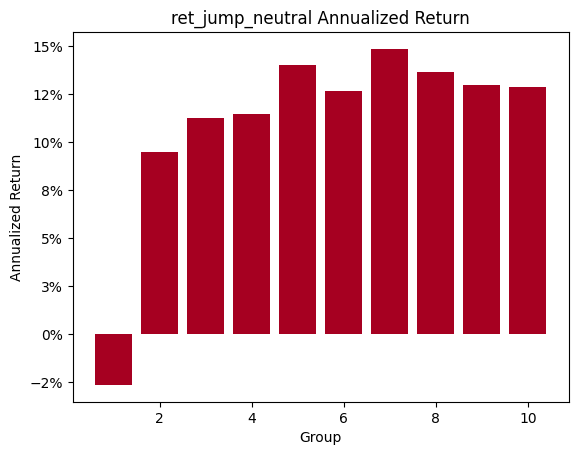

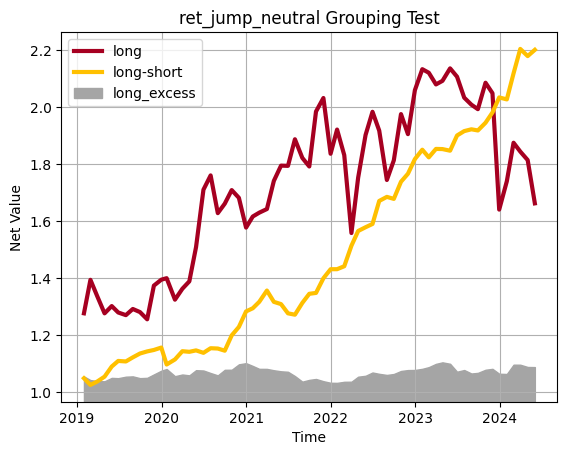

,factor,IC_mean,winning,IC_IR,t,max,min
0,ret_jump_neutral,-0.045763,0.815385,-0.900023,-7.256217,0.080992,-0.175871


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,ret_jump_neutral,0.129016,0.016403,0.399035,0.159508,-0.062559,20.46685


In [17]:
IC, grouped = backtest(
    filename = '../data/ret_jump/neutral_ret_jump.feather',
    factor_col='neutral_factor', factor_name='ret_jump_neutral',
    benchmark='../data/benchmark/benchmark_sample.feather',
    # dirname='../data/ret_jump/backtest1/'
)
display(IC)
display(grouped)

## 点度中心性回测

### N_connect_0_1

In [18]:
cores = np.array(['_num', '_size', '', '_residual'])
filenames = '../data/N_connect/N_connect_0_1/neutral_N_connect' + cores + '.feather'
factor_cols = ['neutral_factor'] * len(cores)
factor_names = 'N_connect' + cores
set_backtest(
    filenames=filenames,
    factor_cols=factor_cols, factor_names=factor_names,
    benchmark='../data/benchmark/benchmark_000906.feather',
    dirname='../data/N_connect/N_connect_0_1/backtest1/'
)

print('-' * 10 + ' hs800 ' + '-' * 10)
set_backtest(
    filenames=filenames,
    factor_cols=factor_cols, factor_names=factor_names,
    benchmark='../data/benchmark/benchmark_000906.feather',
    sample='hs800',
    dirname='../data/N_connect/N_connect_0_1/backtest1_hs800/'
)

print('-' * 10 + ' hs1000 ' + '-' * 10)
set_backtest(
    filenames=filenames,
    factor_cols=factor_cols, factor_names=factor_names,
    benchmark='../data/benchmark/benchmark_000906.feather',
    sample='hs1000',
    dirname='../data/N_connect/N_connect_0_1/backtest1_hs1000/'
)

,factor,IC_mean,winning,IC_IR,t,max,min
0,N_connect_num,0.033435,0.828125,0.682919,5.463351,0.135539,-0.121017
0,N_connect_size,0.035143,0.828125,0.694828,5.558625,0.146744,-0.118299
0,N_connect,0.037101,0.828125,0.708104,5.664832,0.143730,-0.126767
0,N_connect_residual,0.012196,0.625000,0.238625,1.909000,0.114039,-0.125696


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,N_connect_num,0.137631,0.106164,0.743652,0.065244,-0.061241,11.782436
0,N_connect_size,0.146812,0.115112,0.807340,0.064522,-0.090096,9.081106
0,N_connect,0.142911,0.111310,0.776096,0.076917,-0.067847,9.977303
0,N_connect_residual,0.112151,0.081332,0.568994,-0.006778,-0.160994,10.673676


---------- hs800 ----------


,factor,IC_mean,winning,IC_IR,t,max,min
0,N_connect_num,0.009688,0.578125,0.122958,0.983667,0.231052,-0.165151
0,N_connect_size,0.014934,0.562500,0.213400,1.707198,0.204152,-0.161539
0,N_connect,0.013352,0.578125,0.172600,1.380800,0.223027,-0.172498
0,N_connect_residual,0.003278,0.515625,0.043798,0.350385,0.239072,-0.194812


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,N_connect_num,0.067298,0.037622,0.414166,0.024802,-0.083738,12.057521
0,N_connect_size,0.082844,0.052771,0.634524,0.016759,-0.150759,9.111001
0,N_connect,0.081938,0.051888,0.594474,0.021435,-0.106212,10.209482
0,N_connect_residual,0.070591,0.040831,0.500719,0.006235,-0.182552,10.616513


---------- hs1000 ----------


,factor,IC_mean,winning,IC_IR,t,max,min
0,N_connect_num,0.035161,0.765625,0.676574,5.412594,0.181618,-0.108246
0,N_connect_size,0.036845,0.750000,0.618199,4.945589,0.163972,-0.139352
0,N_connect,0.039373,0.781250,0.680268,5.442141,0.181332,-0.135101
0,N_connect_residual,0.017620,0.625000,0.286523,2.292182,0.147752,-0.122902


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,N_connect_num,0.126267,0.095089,0.663581,0.059275,-0.100548,11.804684
0,N_connect_size,0.123103,0.092005,0.642363,0.069258,-0.075998,9.208243
0,N_connect,0.126809,0.095617,0.671054,0.086563,-0.077433,10.164344
0,N_connect_residual,0.089072,0.058840,0.415990,0.003140,-0.186253,10.639342


### N_connect_1_any

In [19]:
cores = np.array(['_num', '_size', ''])
filenames = '../data/N_connect/N_connect_1_any/neutral_N_connect' + cores + '.feather'
factor_cols = ['neutral_factor'] * 3
factor_names = 'N_connect' + cores
set_backtest(
    filenames=filenames,
    factor_cols=factor_cols, factor_names=factor_names,
    benchmark='../data/benchmark/benchmark_000906.feather',
    dirname='../data/N_connect/N_connect_1_any/backtest1/'
)

print('-' * 10 + ' hs800 ' + '-' * 10)
set_backtest(
    filenames=filenames,
    factor_cols=factor_cols, factor_names=factor_names,
    benchmark='../data/benchmark/benchmark_000906.feather',
    sample='hs800',
    dirname='../data/N_connect/N_connect_1_any/backtest1_hs800/'
)

print('-' * 10 + ' hs1000 ' + '-' * 10)
set_backtest(
    filenames=filenames,
    factor_cols=factor_cols, factor_names=factor_names,
    benchmark='../data/benchmark/benchmark_000906.feather',
    sample='hs1000',
    dirname='../data/N_connect/N_connect_1_any/backtest1_hs1000/'
)

,factor,IC_mean,winning,IC_IR,t,max,min
0,N_connect_num,-0.035074,0.625000,-0.446364,-3.570912,0.121009,-0.224008
0,N_connect_size,-0.030425,0.625000,-0.386713,-3.093705,0.133171,-0.199034
0,N_connect,-0.033345,0.609375,-0.417358,-3.338866,0.128456,-0.211188


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,N_connect_num,0.156928,0.124972,0.957801,0.096345,-0.056050,9.569343
0,N_connect_size,0.143376,0.111763,0.874273,0.074880,-0.061511,7.894108
0,N_connect,0.152188,0.120352,0.915278,0.089031,-0.050004,8.421827


---------- hs800 ----------


,factor,IC_mean,winning,IC_IR,t,max,min
0,N_connect_num,-0.015213,0.593750,-0.195441,-1.563525,0.169567,-0.218471
0,N_connect_size,-0.010951,0.609375,-0.137828,-1.102625,0.188136,-0.168633
0,N_connect,-0.013642,0.578125,-0.170677,-1.365415,0.178527,-0.211018


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,N_connect_num,0.092119,0.061810,0.882174,0.042473,-0.089387,9.968874
0,N_connect_size,0.086076,0.055921,0.732457,0.041224,-0.101253,8.165050
0,N_connect,0.088158,0.057949,0.805358,0.039983,-0.116975,8.770259


---------- hs1000 ----------


,factor,IC_mean,winning,IC_IR,t,max,min
0,N_connect_num,-0.038587,0.734375,-0.472000,-3.775999,0.154649,-0.254862
0,N_connect_size,-0.032320,0.671875,-0.403169,-3.225349,0.155811,-0.216792
0,N_connect,-0.036231,0.703125,-0.441478,-3.531822,0.156005,-0.246536


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,N_connect_num,0.112235,0.081413,0.666188,0.073406,-0.141865,10.145961
0,N_connect_size,0.107142,0.076450,0.631436,0.048127,-0.144963,8.584475
0,N_connect,0.115008,0.084116,0.658775,0.065597,-0.155530,8.990237


## 跳跃关联动量因子回测

### 总收益

In [20]:
cores = np.array(['_num', '_size'])
filenames = '../data/peer_ret/neutral_peer' + cores + '.feather'
factor_cols = ['neutral_factor'] * 2
factor_names = 'peer_ret' + cores
set_backtest(
    filenames=filenames,
    factor_cols=factor_cols, factor_names=factor_names,
    benchmark='../data/benchmark/benchmark_000906.feather',
    dirname='../data/peer_ret/backtest1/'
)

,factor,IC_mean,winning,IC_IR,t,max,min
0,peer_ret_num,-0.003228,0.484375,-0.052225,-0.417802,0.153198,-0.139764
0,peer_ret_size,-0.014660,0.593750,-0.263077,-2.104612,0.118527,-0.141054


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,peer_ret_num,0.071956,0.042161,0.319264,-0.035541,-0.283611,20.001041
0,peer_ret_size,0.089516,0.059273,0.448648,-0.012323,-0.231775,20.183791


### 正 / 负 / 非跳跃收益

In [21]:
cores = np.array([
    'posjump_num', 'posjump_size',
    'negjump_num', 'negjump_size',
    'nojump_num', 'nojump_size'
])
filenames = '../data/peer_ret/neutral_peer_' + cores + '.feather'
factor_names = 'relative_' + cores
factor_cols = ['neutral_factor'] * 6
set_backtest(
    filenames=filenames,
    factor_cols=factor_cols, factor_names=factor_names,
    benchmark='../data/benchmark/benchmark_000906.feather',
    dirname='../data/peer_ret/backtest1/'
)

,factor,IC_mean,winning,IC_IR,t,max,min
0,relative_posjump_num,-0.048801,0.750000,-0.747943,-5.983543,0.069749,-0.200988
0,relative_posjump_size,-0.051969,0.828125,-0.813302,-6.506420,0.082908,-0.194396
0,relative_negjump_num,0.050284,0.750000,0.787238,6.297904,0.180442,-0.104413
0,relative_negjump_size,0.049394,0.828125,0.751963,6.015705,0.201159,-0.122481
0,relative_nojump_num,0.037674,0.765625,0.570353,4.562827,0.220922,-0.148096
0,relative_nojump_size,0.033274,0.718750,0.540888,4.327105,0.201426,-0.174770


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,relative_posjump_num,0.144275,0.112640,0.900552,0.081905,-0.072540,13.154160
0,relative_posjump_size,0.139883,0.108359,0.845810,0.079098,-0.095428,13.242679
0,relative_negjump_num,0.158962,0.126955,0.964512,0.098706,-0.073529,13.113915
0,relative_negjump_size,0.137521,0.106058,0.817843,0.092101,-0.071338,12.737970
0,relative_nojump_num,0.162999,0.130889,0.920377,0.130282,-0.091282,17.960634
0,relative_nojump_size,0.149558,0.117789,0.811579,0.103416,-0.114100,18.432234


### 非正跳跃收益

In [22]:
cores = np.array([
    'without_posjump_num', 'without_posjump_size',
    'without_posjump', 'without_posjump_residual'
])
filenames = '../data/peer_ret/neutral_peer_' + cores + '.feather'
factor_names = 'relative_' + cores
factor_cols = ['neutral_factor'] * len(cores)
set_backtest(
    filenames=filenames,
    factor_cols=factor_cols, factor_names=factor_names,
    benchmark='../data/benchmark/benchmark_000906.feather',
    dirname='../data/peer_ret/backtest1/'
)

print('-' * 10 + ' hs800 ' + '-' * 10)
set_backtest(
    filenames=filenames,
    factor_cols=factor_cols, factor_names=factor_names,
    benchmark='../data/benchmark/benchmark_000906.feather',
    sample='hs800',
    dirname='../data/peer_ret/backtest1_hs800/'
)

print('-' * 10 + ' hs1000 ' + '-' * 10)
set_backtest(
    filenames=filenames,
    factor_cols=factor_cols, factor_names=factor_names,
    benchmark='../data/benchmark/benchmark_000906.feather',
    sample='hs1000',
    dirname='../data/peer_ret/backtest1_hs1000/'
)

,factor,IC_mean,winning,IC_IR,t,max,min
0,relative_without_posjump_num,0.053846,0.781250,0.798114,6.384915,0.228976,-0.128277
0,relative_without_posjump_size,0.050861,0.859375,0.782017,6.256139,0.220595,-0.148684
0,relative_without_posjump,0.055513,0.796875,0.805777,6.446220,0.235157,-0.146688
0,relative_without_posjump_residual,0.017892,0.609375,0.306461,2.451686,0.154696,-0.124087


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,relative_without_posjump_num,0.173024,0.140660,1.019740,0.141165,-0.081640,13.979588
0,relative_without_posjump_size,0.160418,0.128373,0.944120,0.144267,-0.078296,14.367149
0,relative_without_posjump,0.167902,0.135668,0.986077,0.150955,-0.084130,13.968014
0,relative_without_posjump_residual,0.132925,0.101578,0.707178,0.050706,-0.108854,15.522003


---------- hs800 ----------


,factor,IC_mean,winning,IC_IR,t,max,min
0,relative_without_posjump_num,0.029726,0.656250,0.332604,2.660829,0.264130,-0.178141
0,relative_without_posjump_size,0.027763,0.687500,0.337255,2.698040,0.234986,-0.189566
0,relative_without_posjump,0.029915,0.656250,0.339804,2.718428,0.253721,-0.193024
0,relative_without_posjump_residual,0.008733,0.609375,0.104537,0.836300,0.270088,-0.171373


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,relative_without_posjump_num,0.137132,0.105678,1.066430,0.093157,-0.117912,13.194056
0,relative_without_posjump_size,0.098311,0.067844,0.725897,0.068619,-0.160133,14.242446
0,relative_without_posjump,0.100183,0.069668,0.727462,0.082096,-0.129506,13.533029
0,relative_without_posjump_residual,0.102196,0.071631,0.878781,0.046198,-0.186401,15.155838


---------- hs1000 ----------


,factor,IC_mean,winning,IC_IR,t,max,min
0,relative_without_posjump_num,0.055917,0.781250,0.777041,6.216328,0.200384,-0.198471
0,relative_without_posjump_size,0.059812,0.875000,0.835570,6.684560,0.212963,-0.204895
0,relative_without_posjump,0.061631,0.859375,0.840008,6.720060,0.210760,-0.211585
0,relative_without_posjump_residual,0.027289,0.687500,0.374175,2.993399,0.221945,-0.151248


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,relative_without_posjump_num,0.168931,0.136671,1.055446,0.151567,-0.079452,14.039779
0,relative_without_posjump_size,0.149865,0.118088,0.887210,0.171728,-0.071048,14.267926
0,relative_without_posjump,0.153149,0.121288,0.905837,0.178479,-0.071665,14.182107
0,relative_without_posjump_residual,0.097561,0.067114,0.476876,0.069364,-0.082385,15.557940
